# RFM Analysis for Customer Segmentation

The goal of this project is to perform an RFM (Recency, Frequency, Monetary) analysis on an e-commerce dataset.  
By segmenting customers into loyalty tiers, we can:

- Identify which customers are most valuable ("Champions").
- Detect customers who are at risk of churn.
- Understand overall revenue dependency on different customer groups.

These insights can support **targeted marketing, retention campaigns, and inventory planning**.




In [2]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime


In [3]:
filepath = '/Users/ankitwalimbe/DA_Projects/rfm-analysis/data/raw/Online_Retail.csv'
df = pd.read_csv(filepath, encoding = 'ISO-8859-1')

In [4]:
df.shape, df.head(10)

((541909, 8),
   InvoiceNo StockCode                          Description  Quantity  \
 0    536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
 1    536365     71053                  WHITE METAL LANTERN         6   
 2    536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
 3    536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
 4    536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   
 5    536365     22752         SET 7 BABUSHKA NESTING BOXES         2   
 6    536365     21730    GLASS STAR FROSTED T-LIGHT HOLDER         6   
 7    536366     22633               HAND WARMER UNION JACK         6   
 8    536366     22632            HAND WARMER RED POLKA DOT         6   
 9    536367     84879        ASSORTED COLOUR BIRD ORNAMENT        32   
 
       InvoiceDate  UnitPrice  CustomerID         Country  
 0  12/1/2010 8:26       2.55     17850.0  United Kingdom  
 1  12/1/2010 8:26       3.39     17850.0  United Kingdom  
 

In [5]:
# Checking for the datatypes
df.dtypes

InvoiceNo       object
StockCode       object
Description     object
Quantity         int64
InvoiceDate     object
UnitPrice      float64
CustomerID     float64
Country         object
dtype: object

## Data Understanding & Cleaning

Before analysis, the dataset required several cleaning steps:

- Removed rows with missing `CustomerID` values.
- Excluded transactions with negative `Quantity` or `UnitPrice`.
- Created a new column `Amount = Quantity × UnitPrice` to represent spend.

This ensured we only analyzed valid customer purchases.


In [6]:
# missing values
df.isna().sum().sort_values(ascending = False).head(10)

CustomerID     135080
Description      1454
StockCode           0
InvoiceNo           0
Quantity            0
InvoiceDate         0
UnitPrice           0
Country             0
dtype: int64

In [7]:
(df['Quantity']<=0).sum(), (df['UnitPrice']<=0).sum(), df['CustomerID'].isna().sum()

(np.int64(10624), np.int64(2517), np.int64(135080))

In [8]:
# Cleamning the data, correcnting the dtype, removing the null and errornous values
# InvoiceDate to dateteime 
df['InvoiceDate'] =  pd.to_datetime(df['InvoiceDate'])

# Dropping rows with no CustomenID 
df = df[df['CustomerID'].notna()].copy()
df['CustomerID']= df['CustomerID'].astype(int)

# Removing negative quantity 
df = df[(df['Quantity']> 0) & (df['UnitPrice'] > 0)].copy()

# Total Amount
df['Amount'] = df['Quantity'] * df['UnitPrice']

df.shape, df[['CustomerID','InvoiceDate','Quantity','UnitPrice','Amount']].head(5)

((397884, 9),
    CustomerID         InvoiceDate  Quantity  UnitPrice  Amount
 0       17850 2010-12-01 08:26:00         6       2.55   15.30
 1       17850 2010-12-01 08:26:00         6       3.39   20.34
 2       17850 2010-12-01 08:26:00         8       2.75   22.00
 3       17850 2010-12-01 08:26:00         6       3.39   20.34
 4       17850 2010-12-01 08:26:00         6       3.39   20.34)

In [9]:
# Checking the cleaning result
df.isna().sum()

InvoiceNo      0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
UnitPrice      0
CustomerID     0
Country        0
Amount         0
dtype: int64

In [10]:
# Checking for negative values 
(df['Quantity'] <= 0).sum(), (df['UnitPrice'] <= 0).sum()

(np.int64(0), np.int64(0))

In [11]:
# Creating a snapshot date to measure recency 
# A baseline  date to measure the recency
snapshot_date = df['InvoiceDate'].max() + pd.Timedelta(days=1)
snapshot_date

Timestamp('2011-12-10 12:50:00')

## RFM Metrics

We calculate three key metrics for each customer:

- **Recency (R):** Days since the last purchase. Lower values = more recent activity.
- **Frequency (F):** Number of unique purchase instances. Higher values = more engaged customers.
- **Monetary (M):** Total spend across all purchases. Higher values = more valuable customers.

Together, these provide a holistic view of customer behavior.


In [ ]:
# Calculating the RFM 
# Grouping by CustomerID, and aggrigating the R,F and M values
rfm = df.groupby('CustomerID').agg(
    Recency = ('InvoiceDate', lambda x: (snapshot_date - x.max()).days), # Difference between the most recent customer purchace and the baseline date
    Frequency = ('InvoiceNo','nunique'),  # Caluculating how often a customer makes a purchase
    Monetary = ('Amount','sum')           # Calcualting how much each customer has spent 
).reset_index()

rfm.head()

,CustomerID,Recency,Frequency,Monetary
0,12346,326,1,77183.60
1,12347,2,7,4310.00
2,12348,75,4,1797.24
3,12349,19,1,1757.55
4,12350,310,1,334.40


## RFM Scoring & Segmentation

- Each metric (R, F, M) is split into **quartiles** (1–4).
- Customers are scored accordingly:
  - High Recency → higher score.
  - High Frequency → higher score.
  - High Monetary → higher score.
- These scores are combined into an overall **RFM Score**.

Using score thresholds, customers are grouped into intuitive segments:
- **Champions** – recent, frequent, and high spenders.
- **Loyal Customers** – buy frequently, strong brand connection.
- **Potential Loyalists** – new but show promising signs.
- **At Risk** – used to buy, but now inactive.
- **Needs Attention** – moderate value, possible to nurture.


In [13]:
# Ensuring no NaN in the columns 
rfm = rfm.dropna(subset=['Recency','Frequency','Monetary']).copy()
# Converting the R,F,M scores to percentile, then cutting them into fixed percentile bands. 
r_pct = rfm['Recency'].rank(pct=True, method='first')
rfm['R_score'] = pd.cut(1-r_pct, bins=[0,.25, .50, .75, 1.0], labels = [1,2,3,4], include_lowest = True).astype(int) # 1-r_pct to invert the ranking, lower recency = better

f_pct = rfm['Frequency'].rank(pct= True, method = 'first' )
rfm['F_score'] = pd.cut(f_pct, bins=[0, .25, .50, .75, 1.0], labels= [1,2,3,4], include_lowest= True).astype(int)

m_pct = rfm['Monetary'].rank(pct=True, method = 'first')
rfm['M_score'] = pd.cut(m_pct, bins=[0, .25, .50, .75, 1.0],  labels=[1,2,3,4], include_lowest= True).astype(int)

# Check
print('Count pre score (R):'); print(rfm['R_score'].value_counts().sort_index())
print( 'Count per score (F)'); print(rfm['F_score'].value_counts().sort_index())
print('Count per score (M)'); print(rfm['M_score'].value_counts().sort_index())

Count pre score (R):
R_score
1    1085
2    1085
3    1084
4    1084
Name: count, dtype: int64
Count per score (F)
F_score
1    1084
2    1085
3    1084
4    1085
Name: count, dtype: int64
Count per score (M)
M_score
1    1084
2    1085
3    1084
4    1085
Name: count, dtype: int64


In [14]:
# Combining the three scores and concatinating them, to preserve the pattern visibility
rfm['RFM_Score'] = rfm['R_score'] + rfm['F_score'] + rfm['M_score'] # Numerical sun
rfm['RFM_Label'] = (rfm['R_score'].astype(str) + rfm['F_score'].astype(str) + rfm['M_score'].astype(str))

rfm[['CustomerID','R_score','F_score','M_score','RFM_Score','RFM_Label']].head()


,CustomerID,R_score,F_score,M_score,RFM_Score,RFM_Label
0,12346,1,1,4,6,114
1,12347,4,4,4,12,444
2,12348,2,3,4,9,234
3,12349,3,1,4,8,314
4,12350,1,1,2,4,112


In [15]:
# runnning a quick check
rfm['RFM_Score'].describe()
print('Count per score (RFM_Score)'); print(rfm['RFM_Score'].value_counts().sort_index())

Count per score (RFM_Score)
RFM_Score
3     302
4     507
5     485
6     513
7     429
8     428
9     413
10    394
11    390
12    477
Name: count, dtype: int64


In [16]:
# Segmenting the customers based on the R,F and M values

def segment_customer(R_score, F_score, M_score):
    if R_score == 4 and F_score >= 3 and F_score >= 3:
        return 'Champions'
    elif R_score >= 3 and  F_score >= 3:
        return 'Loyal Customers'
    elif R_score >= 3 and (F_score >= 2 or M_score >=2):
        return 'Potential Loyalists'
    elif R_score <= 2 and F_score <= 2:
        return 'At Risk'
    elif R_score == 1 and F_score == 1 and M_score == 1:
        return 'Hibernating'
    else:
        return 'Needs Attention'

In [17]:
# Applying the function on each row to assign a sengment 

rfm['Segment'] = rfm.apply(lambda row: segment_customer(row['R_score'], row['F_score'], row['M_score']), axis = 1)

rfm[['CustomerID','R_score','F_score','M_score','RFM_Score','RFM_Label','Segment']].head(10)




,CustomerID,R_score,F_score,M_score,RFM_Score,RFM_Label,Segment
0,12346,1,1,4,6,114,At Risk
1,12347,4,4,4,12,444,Champions
2,12348,2,3,4,9,234,Needs Attention
3,12349,3,1,4,8,314,Potential Loyalists
4,12350,1,1,2,4,112,At Risk
5,12352,3,4,4,11,344,Loyal Customers
6,12353,1,1,1,3,111,At Risk
7,12354,1,1,3,5,113,At Risk
8,12355,1,1,2,4,112,At Risk
9,12356,3,3,4,10,334,Loyal Customers


In [19]:
# Quick view for the segment distribution 
print('Count per segment (Segment)');print(rfm['Segment'].value_counts().sort_index())

Count per segment (Segment)
Segment
At Risk                1514
Champions               863
Loyal Customers         650
Needs Attention         798
Potential Loyalists     513
Name: count, dtype: int64


In [20]:
# Number of cutomer in each segment
seg_count = rfm.groupby('Segment')['CustomerID'].nunique().reset_index()

# renaming the columns
seg_count.columns = ['Segment','Customers']

print(seg_count)

               Segment  Customers
0              At Risk       1514
1            Champions        863
2      Loyal Customers        650
3      Needs Attention        798
4  Potential Loyalists        513


In [21]:
# Calculating the revenue pers segment  
seg_rev = rfm.groupby('Segment')['Monetary'].sum().reset_index()

seg_rev.columns = ['Segment','Revenue'] # Column rename

# Merging seg_count amd seg_rev 
seg_summary = pd.merge(seg_count, seg_rev, on = 'Segment')

# Calculating the % share for each segment
total_rev = seg_summary['Revenue'].sum() # total revenue
seg_summary['Share%'] = round(100 * seg_rev['Revenue']/ total_rev,2)
seg_summary = seg_summary.sort_values(by = 'Revenue', ascending= False)

print(seg_summary)
print(type(seg_summary))



               Segment  Customers      Revenue  Share%
1            Champions        863  4885606.910   54.82
2      Loyal Customers        650  1698965.581   19.07
3      Needs Attention        798  1082918.281   12.15
0              At Risk       1514   772894.102    8.67
4  Potential Loyalists        513   471023.030    5.29
<class 'pandas.core.frame.DataFrame'>


## Visualisation of RFM Insights

We visualize the distribution of Recency, Frequency, and Monetary values,  
as well as segment-wise behaviors, to uncover patterns.

- **Histograms:** Show overall distributions of R, F, M metrics.
- **Scatterplot (F vs M):** Illustrates which customer groups drive higher spend.
- **Violin plots:** Compare monetary value distributions across segments.
- **Bar chart:** Displays each segment’s revenue contribution (% of total).

These visualisations help us interpret customer dynamics at a glance.


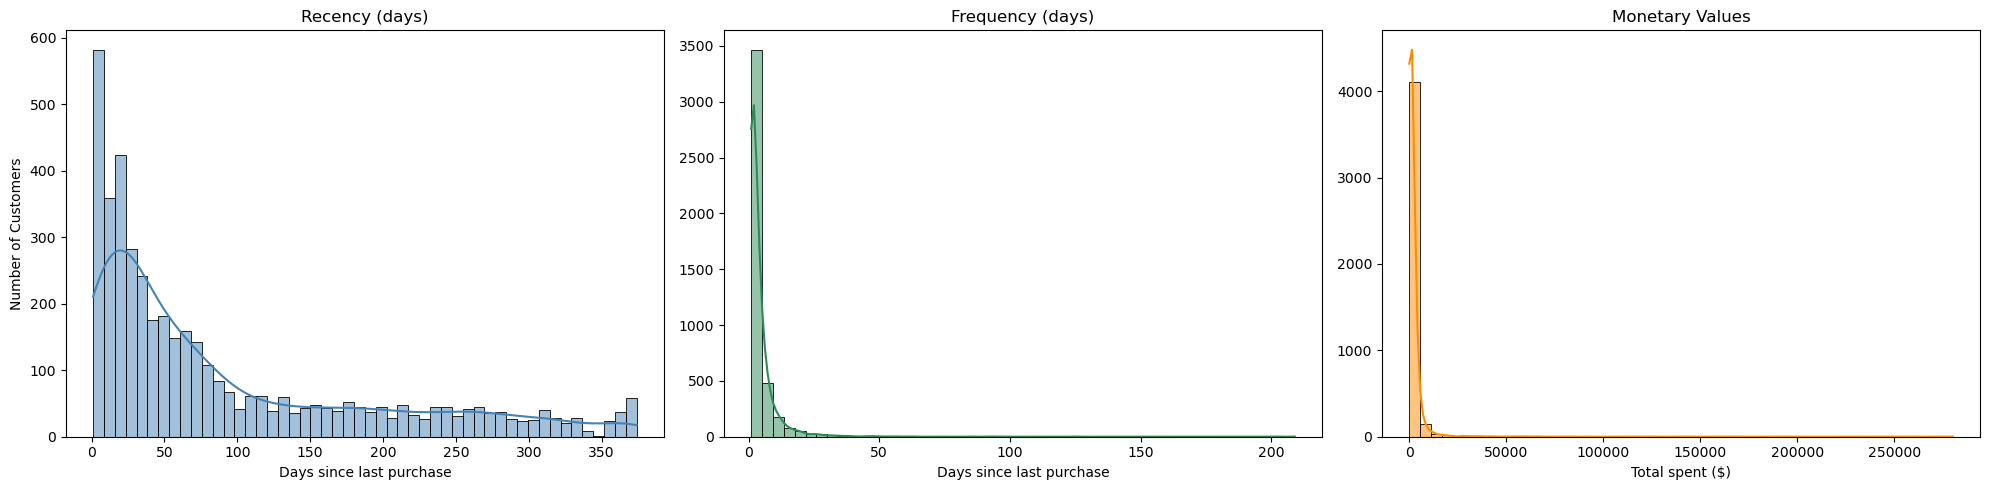

In [31]:
# Data Visualisation 
fig, axes = plt.subplots(1,3, figsize=(20,5))

# Recency distribution
sns.histplot(rfm['Recency'], bins=50, kde = True, color="steelblue", ax=axes[0])
axes[0].set_title("Recency (days)")
axes[0].set_xlabel("Days since last purchase")
axes[0].set_ylabel("Number of Customers")

# Frequency distribution 
sns.histplot(rfm['Frequency'], bins=50, kde = True, color="seagreen", ax=axes[1])
axes[1].set_title("Frequency (days)")
axes[1].set_xlabel("Days since last purchase")
axes[1].set_ylabel("")

# Monetary distribution
sns.histplot(rfm['Monetary'], bins=50, kde = True, color ="darkorange", ax=axes[2])
axes[2].set_title("Monetary Values")
axes[2].set_xlabel("Total spent ($)")
axes[2].set_ylabel("")

plt.tight_layout()
plt.show()


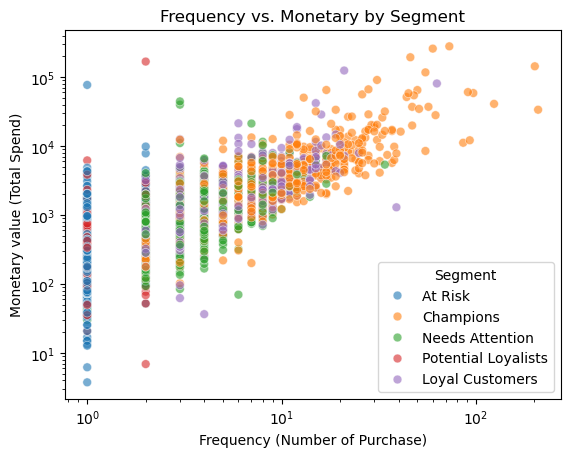

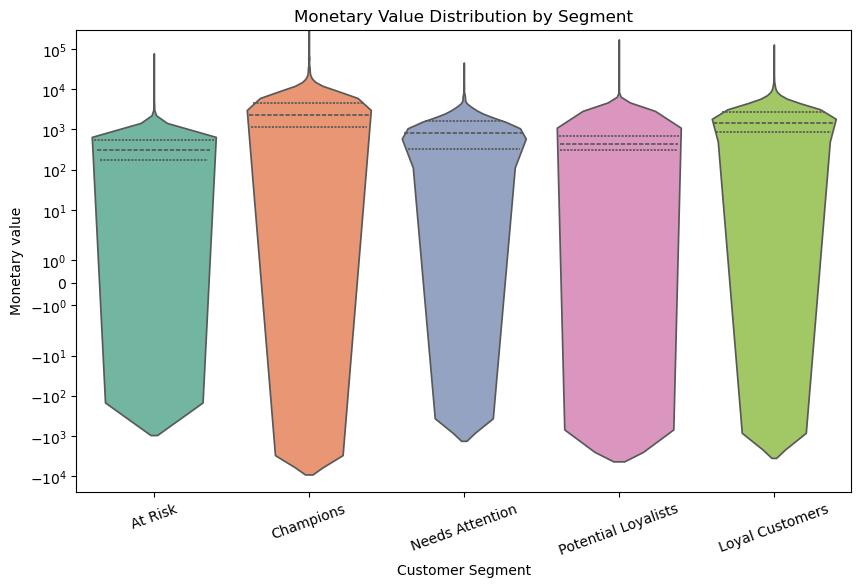

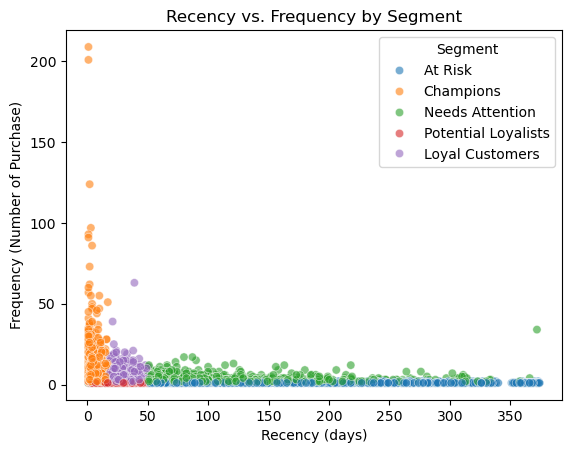

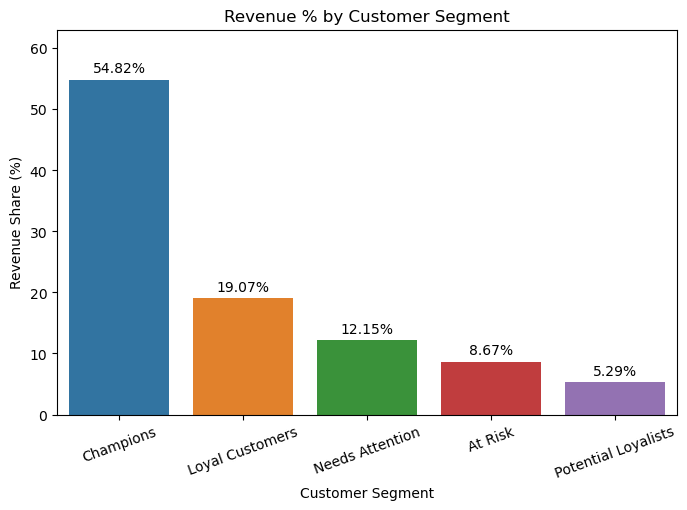

In [51]:
# Scatter plots
# Frequency vs. Monetary  
sns.scatterplot(data=rfm, x='Frequency', y='Monetary',hue='Segment', alpha=0.6, s=40)
plt.xscale('log')
plt.yscale('log')
plt.title("Frequency vs. Monetary by Segment")
plt.xlabel("Frequency (Number of Purchase)")
plt.ylabel("Monetary value (Total Spend)")
plt.show()
# Violin plot to better show the monetary spread
plt.figure(figsize=(10,6))
sns.violinplot(data=rfm, x='Segment', y='Monetary',palette="Set2", hue='Segment', inner="quartile")
plt.yscale('symlog')
plt.xticks(rotation=20)
plt.title("Monetary Value Distribution by Segment")
plt.xlabel("Customer Segment")
plt.ylabel("Monetary value")
plt.show()
# Recency vs. Frequency 
sns.scatterplot(data=rfm, x='Recency', y='Frequency', hue='Segment', alpha=0.6)
plt.title("Recency vs. Frequency by Segment")
plt.xlabel("Recency (days)")
plt.ylabel("Frequency (Number of Purchase)")
plt.show()
# Bar chart to show the revenue% by segment
plt.figure(figsize=(8,5))
ax = sns.barplot(data=seg_summary, x='Segment', y='Share%', hue='Segment')
ax.set_ylim(0, seg_summary['Share%'].max()*1.15)   # top padding
for container in ax.containers:
    ax.bar_label(container, fmt='%.2f%%', padding=3)
plt.xticks(rotation=20)
plt.title("Revenue % by Customer Segment")
plt.xlabel("Customer Segment")
plt.ylabel("Revenue Share (%)")
plt.show()

# Insights & Recommendations

- **Champions (~55% of revenue):**  
  High-value customers; focus on retention strategies, exclusive offers, and loyalty programs.

- **Loyal Customers (~19% of revenue):**  
  Important long-term group; encourage upselling and cross-selling.

- **At Risk (~9% of revenue):**  
  Previously active but now inactive; re-engagement campaigns (discounts, personalized emails) could recover them.

- **Potential Loyalists (~5% of revenue):**  
  Small but promising group; targeted nurturing can convert them into Loyal Customers or Champions.

- **Needs Attention (~12% of revenue):**  
  Medium-spending group; campaigns to increase frequency or average order value can grow their contribution.

**Overall takeaway:**  
The company is highly dependent on Champions for revenue.  
Balancing retention of Champions with reactivation of At Risk customers and nurturing Potential Loyalists will stabilize revenue and reduce churn risk.


# Conclusion

The RFM analysis reveals that **Champions drive over half of total revenue**, making them critical for business stability.  
At the same time, **At Risk and Potential Loyalist customers highlight opportunities** for re-engagement and growth.  
By focusing on **retaining top customers while nurturing the next tier**, the company can reduce churn, strengthen loyalty, and build more balanced revenue streams.
